In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense
from keras.preprocessing.image import ImageDataGenerator

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Fitting Images with The Model**

In [ ]:
train_datagen = ImageDataGenerator(rescale = 1./255, shear_range= 0.2, zoom_range= 0.2, horizontal_flip= True)

In [ ]:
test_datagen = ImageDataGenerator(rescale = 1./255)

In [ ]:
training_dataset = train_datagen.flow_from_directory('/content/drive/MyDrive/Alzheimer Dataset/Training', target_size= (64, 64), batch_size= 32, class_mode= 'binary')

Found 507 images belonging to 2 classes.


In [ ]:
test_dataset = test_datagen.flow_from_directory('/content/drive/MyDrive/Alzheimer Dataset/Testing', target_size= (64, 64), batch_size= 32, class_mode= 'binary')

Found 150 images belonging to 2 classes.


# **VGG 19**

In [ ]:
from tensorflow.keras import layers, models

def VGG19(input_shape=(64, 64, 3), num_classes=1):
    model = models.Sequential()

    # Block 1
    model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape))
    model.add(layers.MaxPooling2D((2, 2), strides=(2, 2)))

    # Block 2
    model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2, 2), strides=(2, 2)))

    # Flatten and fully connected layers
    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(num_classes, activation='sigmoid'))

    return model

# Create VGG-19 model
vgg19_model = VGG19(input_shape=(64, 64, 3), num_classes=1)

# Compile the model
vgg19_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Display the model architecture
vgg19_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_31 (Conv2D)          (None, 64, 64, 32)        896       
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 32, 32, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_32 (Conv2D)          (None, 32, 32, 32)        9248      
                                                                 
 max_pooling2d_22 (MaxPoolin  (None, 16, 16, 32)       0         
 g2D)                                                            
                                                                 
 flatten_7 (Flatten)         (None, 8192)              0         
                                                                 
 dense_12 (Dense)            (None, 128)              

Epoch 1/50
16/16 [==============================] - 7s 397ms/step - loss: 0.6386 - accuracy: 0.6489 - val_loss: 0.8260 - val_accuracy: 0.4733
Epoch 2/50
16/16 [==============================] - 7s 424ms/step - loss: 0.5699 - accuracy: 0.6844 - val_loss: 0.5867 - val_accuracy: 0.5733
Epoch 3/50
16/16 [==============================] - 6s 394ms/step - loss: 0.4699 - accuracy: 0.7692 - val_loss: 0.3984 - val_accuracy: 0.9000
Epoch 4/50
16/16 [==============================] - 5s 328ms/step - loss: 0.3417 - accuracy: 0.8639 - val_loss: 0.2939 - val_accuracy: 0.8733
Epoch 5/50
16/16 [==============================] - 9s 576ms/step - loss: 0.2774 - accuracy: 0.8797 - val_loss: 0.3427 - val_accuracy: 0.8267
Epoch 6/50
16/16 [==============================] - 5s 323ms/step - loss: 0.2456 - accuracy: 0.8994 - val_loss: 0.8372 - val_accuracy: 0.6733
Epoch 7/50
16/16 [==============================] - 8s 523ms/step - loss: 0.2521 - accuracy: 0.8895 - val_loss: 0.1931 - val_accuracy: 0.9133
Epoch 

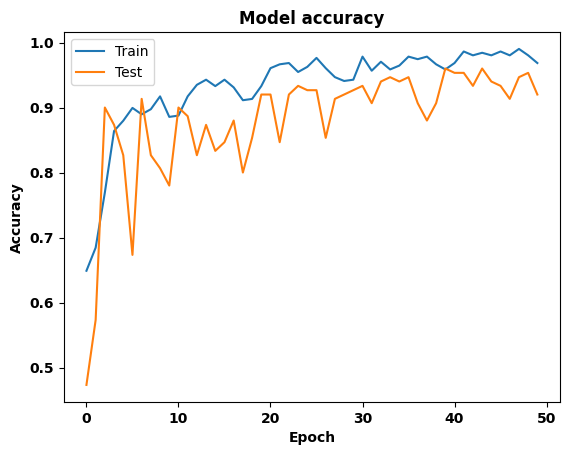

In [ ]:
history = vgg19_model.fit(x = training_dataset, validation_data = test_dataset, epochs = 50)


# Plot training & validation accuracy values
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy', fontweight = 'bold')
plt.xlabel('Epoch', fontweight = 'bold')
plt.ylabel('Accuracy', fontweight = 'bold')
plt.xticks(fontweight = 'bold')
plt.yticks(fontweight = 'bold')
plt.legend(['Train', 'Test'], loc='upper left')
# plt.show()

plt.savefig('VGG 19 plot.png', dpi=800)

# **Resnet50**

In [ ]:
from tensorflow.keras import layers, models

# ... (Previous definitions for identity_block and convolutional_block)

def ResNet50(input_shape=(64, 64, 3), classes=1):
    """
    Implementation of the popular ResNet50 the following architecture:
    CONV2D -> BATCHNORM -> RELU -> MAXPOOL -> CONVBLOCK -> IDBLOCK*2 -> CONVBLOCK -> IDBLOCK*3
    -> CONVBLOCK -> IDBLOCK*5 -> CONVBLOCK -> IDBLOCK*2 -> AVGPOOL -> TOPLAYER

    Arguments:
    input_shape -- shape of the images of the dataset
    classes -- integer, number of classes

    Returns:
    model -- a Model() instance in Keras
    """

    # Define the input as a tensor with shape input_shape
    X_input = layers.Input(input_shape)

    # Zero-Padding
    X = layers.ZeroPadding2D((3, 3))(X_input)

    # Stage 1
    X = layers.Conv2D(32, (3, 3), strides=(2, 2), name='conv1', kernel_initializer='glorot_uniform')(X)
    X = layers.BatchNormalization(axis=3, name='bn_conv1')(X)
    X = layers.Activation('relu')(X)
    X = layers.MaxPooling2D((3, 3), strides=(2, 2))(X)

    # Stage 2
    X = convolutional_block(X, f=3, filters=[64, 64, 256], stage=2, block='a', s=1)
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='b')
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='c')

    # ... Continue with additional stages (Stage 3, Stage 4, Stage 5)

    # AVGPOOL (≈1 line). Use "X = AveragePooling2D(...)(X)"
    X = layers.AveragePooling2D(pool_size=(2, 2), name='avg_pool')(X)

    # output layer
    X = layers.Flatten()(X)
    X = layers.Dense(classes, activation='sigmoid', name='fc' + str(classes), kernel_initializer='glorot_uniform')(X)

    # Create model
    model = models.Model(inputs=X_input, outputs=X, name='ResNet50')

    return model

Epoch 1/45
16/16 [==============================] - 20s 859ms/step - loss: 2.0562 - accuracy: 0.6410 - val_loss: 0.7091 - val_accuracy: 0.4733
Epoch 2/45
16/16 [==============================] - 11s 689ms/step - loss: 0.5557 - accuracy: 0.8323 - val_loss: 0.7382 - val_accuracy: 0.4733
Epoch 3/45
16/16 [==============================] - 13s 807ms/step - loss: 0.2889 - accuracy: 0.9073 - val_loss: 0.9605 - val_accuracy: 0.4733
Epoch 4/45
16/16 [==============================] - 12s 772ms/step - loss: 0.2856 - accuracy: 0.8915 - val_loss: 0.9945 - val_accuracy: 0.4733
Epoch 5/45
16/16 [==============================] - 14s 867ms/step - loss: 0.2190 - accuracy: 0.9211 - val_loss: 1.2928 - val_accuracy: 0.4733
Epoch 6/45
16/16 [==============================] - 13s 791ms/step - loss: 0.1515 - accuracy: 0.9448 - val_loss: 1.1225 - val_accuracy: 0.4733
Epoch 7/45
16/16 [==============================] - 14s 884ms/step - loss: 0.1197 - accuracy: 0.9546 - val_loss: 1.3003 - val_accuracy: 0.4733

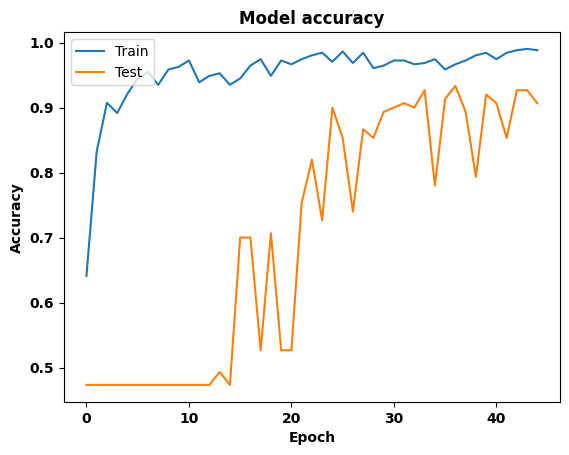

In [ ]:
# Create ResNet-50 model
resnet50_model = ResNet50(input_shape=(64, 64, 3), classes=1)

# Compile the model
resnet50_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = resnet50_model.fit(training_dataset, epochs=45, validation_data=test_dataset)

# Plot training & validation accuracy values
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy', fontweight='bold')
plt.xlabel('Epoch', fontweight='bold')
plt.ylabel('Accuracy', fontweight='bold')
plt.xticks(fontweight='bold')
plt.yticks(fontweight='bold')
plt.legend(['Train', 'Test'], loc='upper left')
# plt.show()

# Save the plot
plt.savefig('ResNet-50_plot.png', dpi=800)

# **Inception V3**

In [ ]:
from tensorflow.keras import layers, models

def InceptionV3(input_shape=(64, 64, 3), classes=1):
    """
    Implementation of the InceptionV3 architecture

    Arguments:
    input_shape -- shape of the images of the dataset
    classes -- integer, number of classes

    Returns:
    model -- a Model() instance in Keras
    """

    # Define the input as a tensor with shape input_shape
    X_input = layers.Input(input_shape)

    # Stage 1
    X = layers.Conv2D(32, (3, 3), strides=(2, 2), padding='valid', activation='relu')(X_input)
    X = layers.Conv2D(32, (3, 3), activation='relu')(X)
    X = layers.Conv2D(64, (3, 3), padding='same', activation='relu')(X)
    X = layers.MaxPooling2D((3, 3), strides=(2, 2))(X)

    # Stage 2
    X = layers.Conv2D(80, (1, 1), activation='relu')(X)
    X = layers.Conv2D(192, (3, 3), activation='relu')(X)
    X = layers.MaxPooling2D((3, 3), strides=(2, 2))(X)

    # Inception blocks
    X = inception_block(X, filters=[64, 128, 128, 192, 32, 96, 96], stage=3, block='a')
    X = inception_block(X, filters=[64, 128, 128, 192, 32, 96, 96], stage=3, block='b')
    X = inception_block(X, filters=[64, 128, 128, 192, 32, 96, 96], stage=3, block='c')

    # ... Continue with additional Inception blocks

    # Final layer
    X = layers.GlobalAveragePooling2D()(X)
    X = layers.Dense(classes, activation='sigmoid')(X)

    # Create model
    model = models.Model(inputs=X_input, outputs=X, name='InceptionV3')

    return model

def inception_block(X, filters, stage, block):
    """
    Implementation of the Inception block

    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network

    Returns:
    X -- output of the Inception block, tensor of shape (n_H, n_W, n_C)
    """

    # Retrieve filters
    F1, F2, F3, F4, F5, F6, F7 = filters

    # Define the name basis
    conv_name_base = 'inception' + str(stage) + block + '_branch'

    # Branch 1
    X_1 = layers.Conv2D(F1, (1, 1), activation='relu', name=conv_name_base + '1')(X)

    # Branch 2
    X_2 = layers.Conv2D(F2, (1, 1), activation='relu', name=conv_name_base + '2a')(X)
    X_2 = layers.Conv2D(F3, (3, 3), padding='same', activation='relu', name=conv_name_base + '2b')(X_2)

    # Branch 3
    X_3 = layers.Conv2D(F4, (1, 1), activation='relu', name=conv_name_base + '3a')(X)
    X_3 = layers.Conv2D(F5, (5, 5), padding='same', activation='relu', name=conv_name_base + '3b')(X_3)

    # Branch 4
    X_4 = layers.MaxPooling2D((3, 3), strides=(1, 1), padding='same', name=conv_name_base + '4a')(X)
    X_4 = layers.Conv2D(F6, (1, 1), activation='relu', name=conv_name_base + '4b')(X_4)

    # Concatenate the branches
    X = layers.concatenate([X_1, X_2, X_3, X_4], axis=3)

    return X

# Create InceptionV3 model
inception_model = InceptionV3(input_shape=(64, 64, 3), classes=1)

# Compile the model
inception_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Display the model architecture
inception_model.summary()

Model: "InceptionV3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 conv2d_33 (Conv2D)             (None, 31, 31, 32)   896         ['input_9[0][0]']                
                                                                                                  
 conv2d_34 (Conv2D)             (None, 29, 29, 32)   9248        ['conv2d_33[0][0]']              
                                                                                                  
 conv2d_35 (Conv2D)             (None, 29, 29, 64)   18496       ['conv2d_34[0][0]']              
                                                                                        

Epoch 1/50
16/16 [==============================] - 22s 930ms/step - loss: 0.6689 - accuracy: 0.6686 - val_loss: 0.7167 - val_accuracy: 0.4733
Epoch 2/50
16/16 [==============================] - 16s 1s/step - loss: 0.6273 - accuracy: 0.6686 - val_loss: 0.7270 - val_accuracy: 0.4733
Epoch 3/50
16/16 [==============================] - 13s 813ms/step - loss: 0.4908 - accuracy: 0.6746 - val_loss: 0.4651 - val_accuracy: 0.8400
Epoch 4/50
16/16 [==============================] - 17s 1s/step - loss: 0.3484 - accuracy: 0.8343 - val_loss: 0.4171 - val_accuracy: 0.8400
Epoch 5/50
16/16 [==============================] - 15s 915ms/step - loss: 0.3317 - accuracy: 0.8343 - val_loss: 0.5006 - val_accuracy: 0.8067
Epoch 6/50
16/16 [==============================] - 15s 917ms/step - loss: 0.3094 - accuracy: 0.8580 - val_loss: 0.3090 - val_accuracy: 0.8800
Epoch 7/50
16/16 [==============================] - 16s 1s/step - loss: 0.2818 - accuracy: 0.8659 - val_loss: 0.5850 - val_accuracy: 0.7400
Epoch 8/

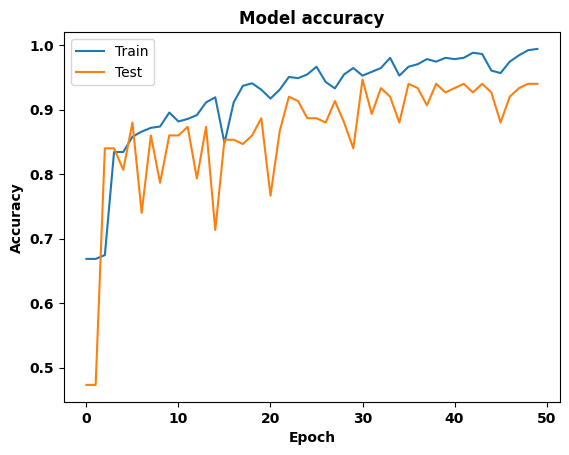

In [ ]:
# Train the model
history = inception_model.fit(training_dataset, epochs=50, validation_data=test_dataset)

# Plot training & validation accuracy values
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy', fontweight='bold')
plt.xlabel('Epoch', fontweight='bold')
plt.ylabel('Accuracy', fontweight='bold')
plt.xticks(fontweight='bold')
plt.yticks(fontweight='bold')
plt.legend(['Train', 'Test'], loc='upper left')
# plt.show()

# Save the plot
plt.savefig('Inception V3_plot.png', dpi=800)